In [1]:
# Необходимые импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Реализация метода опорных векторов

In [2]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        # коэффицент L2 регуляризации
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y

        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        # метки классов из {0, 1} переделываем в {-1, 1}
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            y_i = y_label[index]
            # умножаем строку признаков на вектор весов
            condition = y_i * (np.dot(x_i, self.w) - self.b) >= 1
            # Если верно, то hinge loss равна 0 и производная берется от регуляризатора
            if condition:
                dw = 2 * self.lmda * self.w
                db = 0
            # Если нет, то hinge loss равна 1 - y_i*(w*x_i - b); в итоге производная чуть сложнее
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_i)
                db = y_i
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Реализация метода Naive Bayes

In [3]:
class NBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, priors=None, alpha=1):
        # если знаем, то можем указать распределение классов, а не считать его по обучающей выборке
        self.priors = priors
        self.alpha = alpha

    def fit(self, X, y):
        n, m = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._likelihoods = np.zeros((n_classes, n), dtype=np.float64)
        self.class_values = {}

        # расчет вероятностей классов P(c)
        if self.priors is None:
            self.priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c] # элементы с классом с
            self.class_values[c] = X_c

            if self.priors[idx] == 0:
                self.priors[idx] = X_c.shape[0] / float(n)

            for ix, x in enumerate(X):
                self._likelihoods[idx, ix] = self.likelihood(idx, x)
        print(self.class_values)
        return self

    def predict(self, X):
        y_pred = [self._predict_sample(ix) for ix, _ in enumerate(X)]
        return np.array(y_pred)

    def _predict_sample(self, ix):
        posteriors = []
        for idx, c in enumerate(self._classes):
            posterior = np.prod(self._likelihoods[idx, ix])
            prior = self.priors[idx]
            posterior = posterior * prior
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]

    def likelihood(self, class_idx, x):
        def M(i, c, x, f_num): # количество элементов класса c со значением признака x = i
            return np.count_nonzero(c[x[f_num] == i])

        c = self.class_values[self._classes[class_idx]]
        ms = [M(j, c, x, f_num) + self.alpha for f_num, j in enumerate(x)]
        p_ic = [(M(i, c, x, f_num) + self.alpha) / np.sum(ms) for f_num, i in enumerate(x)]
        return np.prod(p_ic)

    def get_params(self, deep=True):
        return {"priors": self.priors, "alpha": self.alpha}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Датасет

In [4]:
# https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Описание датасета:

- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)
Необходимо решить задачу классификации и научиться предсказывать целевой признак target имеет ли пациент заболевание сердца.

# EDA

In [5]:
df.target.value_counts()

,count
target,
1,526
0,499


Видим, что датасет сбалансирован, у целевого признака примерно одинаковое количество значений как для 1, так и для 0.
Можем отобразить это на диаграмме:

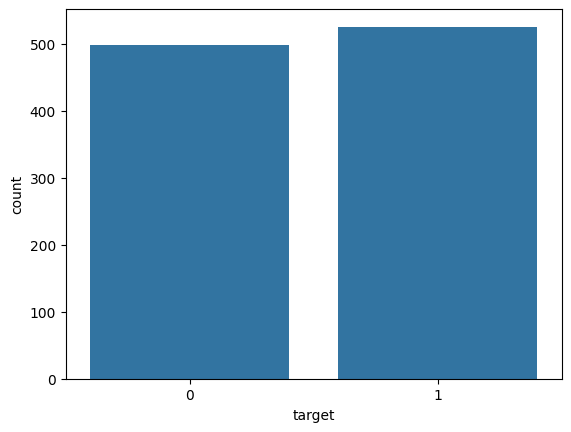

In [6]:
sns.countplot(x="target", data=df)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Видим, что нет null значений, 13 признаков у нас целые, и 1 с плавающей точкой.

Посмотрим на диаграмму наличия сердечного признака в зависимости от возраста.

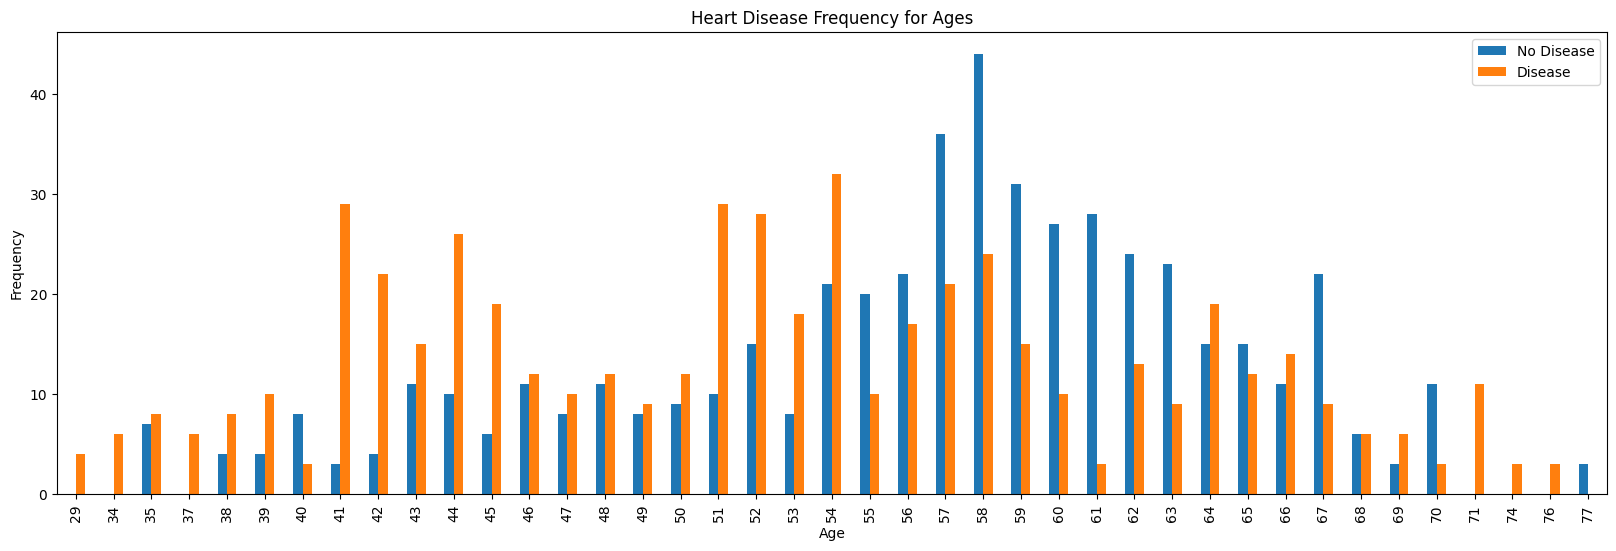

In [8]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

Видим, что больше всего переживают приступы в возрасте от 41-45 и 51-54, в то время люди без приступов в большинстве своем находятся на промежутке от 55-63 лет.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и уровня холестерина.

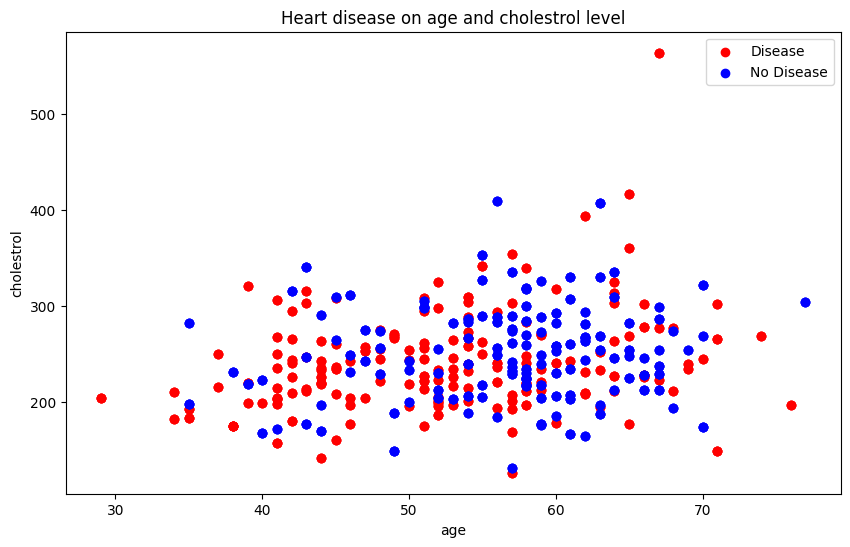

In [9]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.chol[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.chol[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and cholestrol level")
plt.xticks(rotation = 0);

Видим, что люди от 41-45 и 51-54 имеют уровень холестерина меньше, чем у людей от 55-63 лет. У первых количество сердечных приступов меньше, чем у вторых.

Построим диаграмму количества сердечных приступов в зависимости от пола.

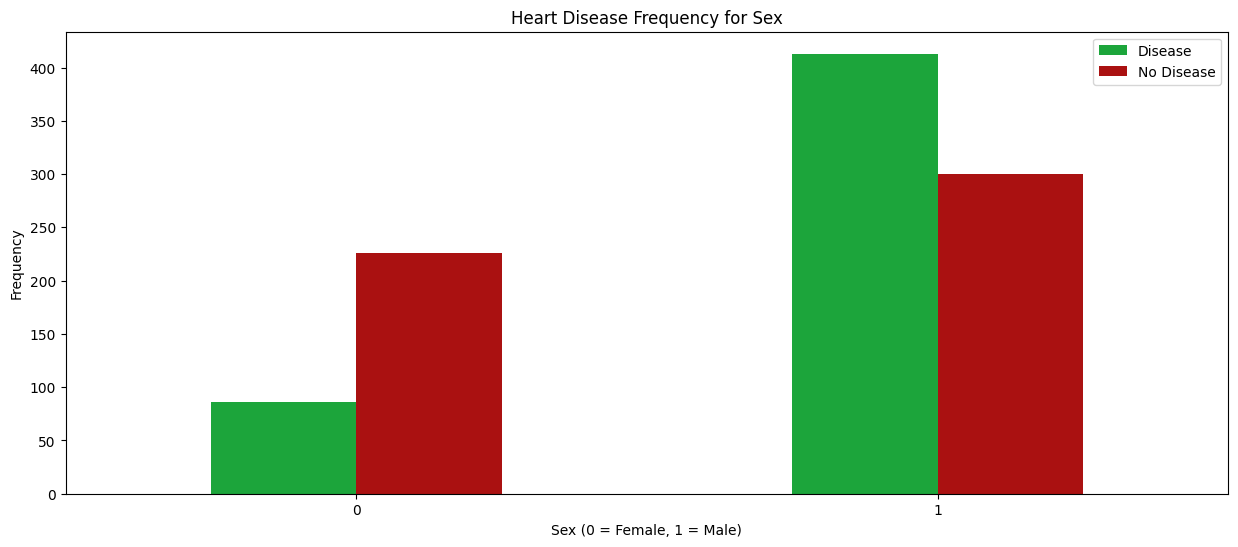

In [10]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Disease", "No Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что в большинстве своем с сердечным приступом сталкиваются мужчины.

Посмотрим на то, как меняется количество приступов в зависимости от возраста и от максимальной частоты сердечных сокращений.

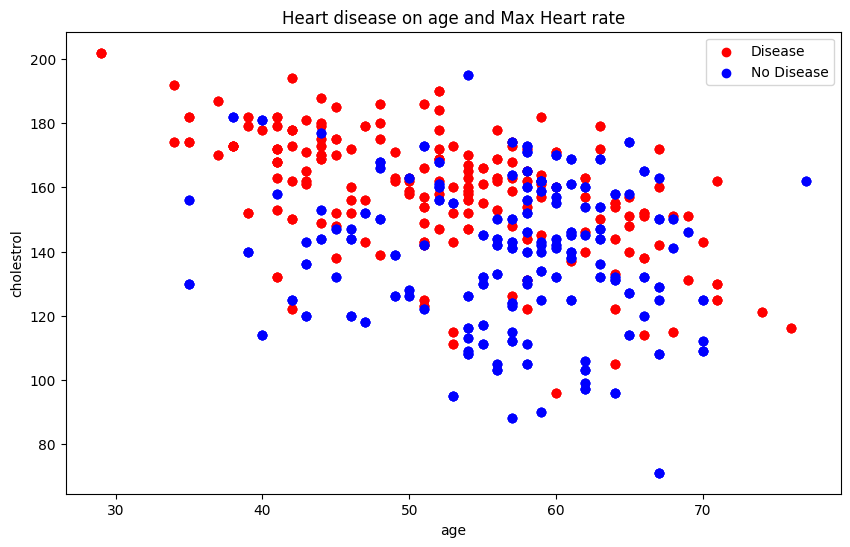

In [11]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1],
            df.thalach[df.target ==1],
            color = "red")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Heart disease on age and Max Heart rate")
plt.xticks(rotation = 0);

Видим, что частота сокращений у людей проблемного возраста выше. У них же и наблюдается больше всего сердечных приступов. Напротив, у людей с меньшей частотой сокращений наблюдается меньше сердечных приступов, и они находятся как раз в том, возрасте, что мы наблюдали ранее.

Посмотрим на то, как меняется количество сердечных приступов в зависимости от типа боли в груди.

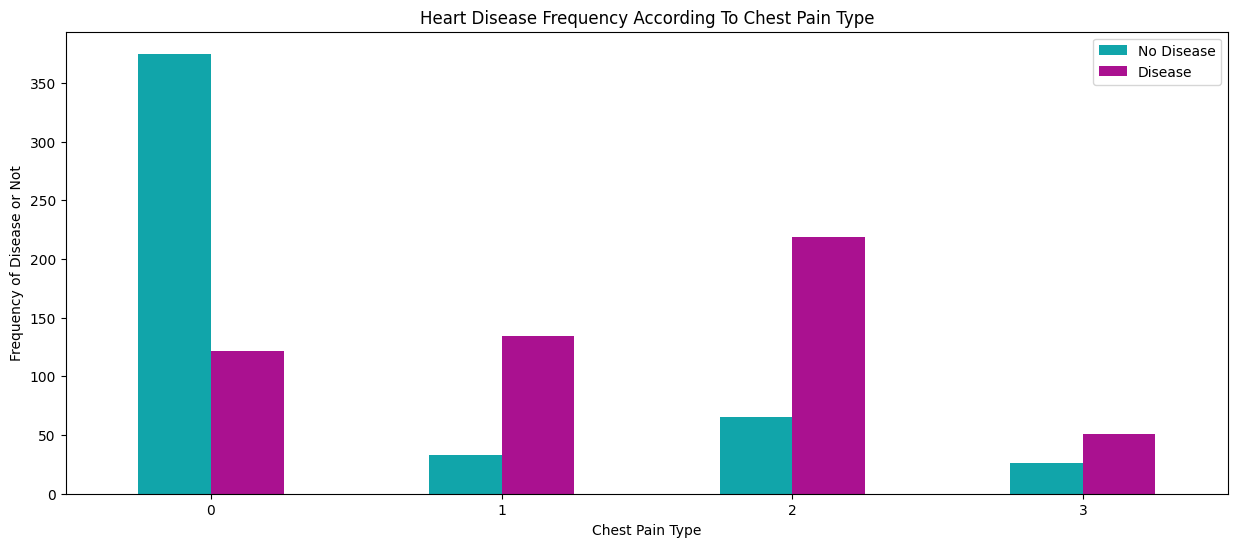

In [12]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15,6),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видно, что большинство пострадавших сталкивались с болью типа 2, меньше всего сталкивались с типом 3. Большинство избежавших приступа сталкивались с болью типа 0, а меньше всего - с типом 3.

Посмотрим на количество приступов в зависимости от пика физической нагрузки

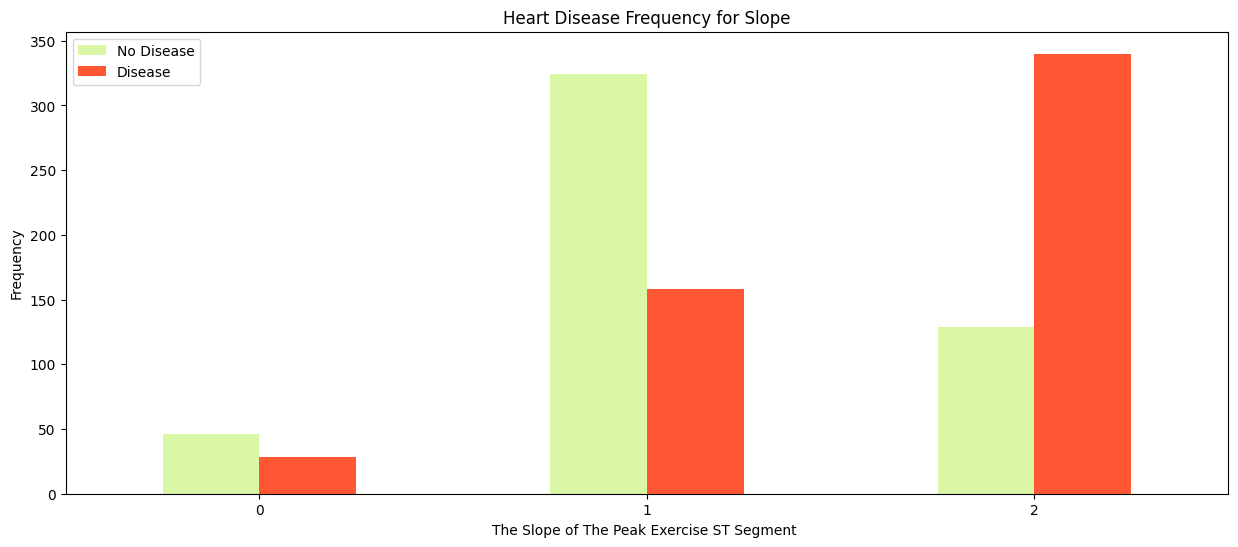

In [13]:
pd.crosstab(df.slope,df.target).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

Видим, что большинство пострадавших находятся в типе 2, а большинство переживших - в типе 1. В тип 0 не попало меньше всего людей.

Посмотрим на количество приступов в зависимости от количества сахара в крови во время голодания.

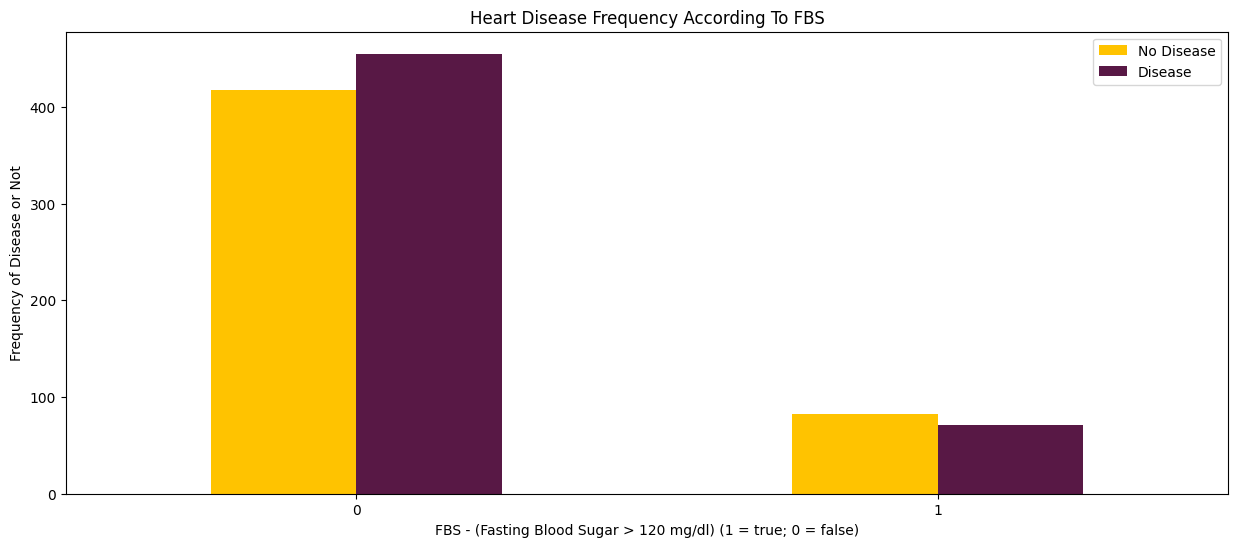

In [14]:
pd.crosstab(df.fbs,df.target).plot(kind="bar",figsize=(15,6),color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видим, большинство людей, которые пережили приступ, имели пониженный сахар. Однако большинство людей в принципе (и среди тех, кто не пережл приступ) в выборке имели пониженный сахар.

Посмотрим на корреляцию признаков нашего датасета

<Axes: >

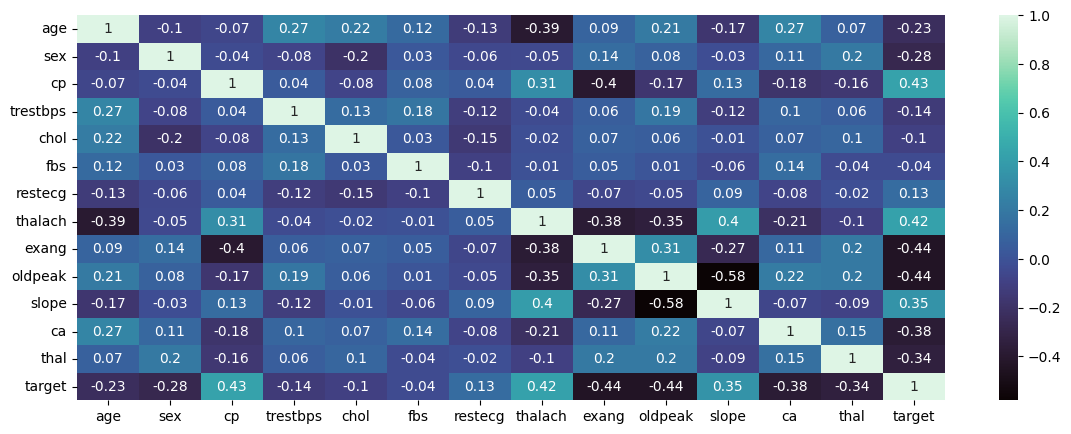

In [15]:
plt.figure(figsize = (14,5))
sns.heatmap(round(df.corr(),2),annot=True,cmap = 'mako')

Видно, что наибольшая корреляция признака target наблюдается с признаком slope, thalach и cp

# Feature Engineering

## Преобразование категориальных данных
Преобразуем категориальные признаки, закодировав их.

In [16]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,False,False,False,False,False,False,True,False,False,True
1,53,1,140,203,1,0,155,1,3.1,0,...,False,False,False,False,False,False,True,True,False,False
2,70,1,145,174,0,1,125,1,2.6,0,...,False,False,False,False,False,False,True,True,False,False
3,61,1,148,203,0,1,161,0,0.0,1,...,False,False,False,False,False,False,True,False,False,True
4,62,0,138,294,1,1,106,0,1.9,3,...,False,False,False,False,False,True,False,False,True,False


## Разделение выборки

In [17]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Масштабирование

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,-0.585840,0.654654,-0.779454,-1.935031,-0.414039,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
1,1.051477,-1.527525,2.741732,1.610634,-0.414039,0.909846,0.202882,1.377507,-0.912152,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
2,-0.040068,-1.527525,-1.347387,0.442176,-0.414039,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,-0.959362,1.094711
3,0.505705,0.654654,0.186033,-0.222636,-0.414039,0.909846,0.508376,-0.725949,-0.473720,-0.725467,...,-0.430083,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,-0.265511,1.042360,-0.913483
4,-0.367531,0.654654,-0.381900,-0.001032,2.415229,-0.983742,0.726586,-0.725949,1.192321,-0.725467,...,-0.430083,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.265511,1.042360,-0.913483


## Подбор наилучших признаков

In [19]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  17
Выбранные признаки:  ['sex', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


 Избавимся от ненужных признаков

In [20]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,sex,trestbps,chol,restecg,thalach,exang,oldpeak,ca,cp_0,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_1,slope_2
0,0.654654,-0.779454,-1.935031,-0.983742,-1.019094,-0.725949,-0.210661,2.171691,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
1,-1.527525,2.741732,1.610634,0.909846,0.202882,1.377507,-0.912152,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
2,-1.527525,-1.347387,0.442176,-0.983742,0.770228,-0.725949,-0.912152,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,-0.959362,1.094711
3,0.654654,0.186033,-0.222636,0.909846,0.508376,-0.725949,-0.473720,-0.725467,1.029709,-0.622478,-0.293416,-0.049447,-0.26287,-1.070793,1.227862,1.042360,-0.913483
4,0.654654,-0.381900,-0.001032,-0.983742,0.726586,-0.725949,1.192321,-0.725467,-0.971148,1.606483,-0.293416,-0.049447,-0.26287,0.933888,-0.814424,1.042360,-0.913483


In [21]:
x_train_scaled.to_csv('x_train_scaled.csv', encoding='utf-8', index=False)

# Подбор гиперпараметров

## SVMClassifier - моя реализация

In [22]:
learning_rate_grid = [0.1, 0.001, 0.0001]
iter_num_grid = [100, 1000, 5000, 10000]
lmda_grid = [0.1, 0.001, 0.0001]

cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMClassifier(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lmda": lmda_grid}],
                        cv=cv, verbose=5)
_ = searcher.fit(x_train_scaled, y_train)

optimal_learning_rate = searcher.best_params_["learning_rate"]
print("Best learning_rate = %.4f:", optimal_learning_rate)

optimal_iter_num = searcher.best_params_["iter_num"]
print("Best iter_num = %.4f", optimal_iter_num)

optimal_lmda = searcher.best_params_["lmda"]
print("Best lmda = %.4f", optimal_lmda)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.799 total time=   2.6s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.835 total time=   2.0s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.811 total time=   1.3s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.848 total time=   1.2s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.744 total time=   1.4s
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.835 total time=   2.4s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.829 total time=   1.8s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.841 total time=   1.2s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.866 total time=   2.5s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.750 total time=   1.9s
[CV 1/5] END iter_num=100, learning_rate=0.1, lm

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best learning_rate = %.4f: 0.001
Best iter_num = %.4f 100
Best lmda = %.4f 0.001


## NBClassifier - моя реализация

In [23]:
priors_grid = [None, [0.62, 0.38], [0.5, 0.5]]
alpha_grid = np.logspace(0, -9, num=50)

nb = NBClassifier()
cv = StratifiedKFold(5)

searcher = GridSearchCV(nb,
                        [{"priors": priors_grid, "alpha": alpha_grid}],
                        cv=cv)
searcher.fit(x_train_scaled.to_numpy(), y_train.to_numpy())

print("best estimator: " + str(searcher.best_estimator_))
print("best params: " + str(searcher.best_params_))
print('best score:', searcher.best_score_)

Выходные данные были обрезаны до нескольких последних строк (5000).
         1.04235982, -0.91348339],
       [ 0.65465367, -0.21152045, -0.32336505, ...,  1.22786207,
         1.04235982, -0.91348339],
       ...,
       [ 0.65465367,  0.46999928, -0.76657318, ...,  1.22786207,
        -0.95936161,  1.09471066],
       [ 0.65465367,  0.46999928,  1.08684264, ...,  1.22786207,
        -0.95936161,  1.09471066],
       [ 0.65465367, -1.12021343, -0.30321922, ..., -0.81442373,
        -0.95936161,  1.09471066]]), 1: array([[-1.52752523,  2.74173173,  1.61063407, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [-1.52752523, -1.34738668,  0.44217627, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [ 0.65465367,  0.18603272, -0.22263592, ...,  1.22786207,
         1.04235982, -0.91348339],
       ...,
       [ 0.65465367, -0.09793383, -0.52482329, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [ 0.65465367, -0.09793383, -0.62555241, ..., -0.81442373,
   

## LogisticRegression библиотечный

In [40]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(x_train_scaled, y_train)

print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

best estimator: LogisticRegression(C=0.60001)
best params: {'C': 0.60001}
best score: 0.8695121951219512


## SVM библиотечный

In [25]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv,
                        param_grid=dict(kernel=kernel,C=C, gamma=gamma))
grid_svm.fit(x_train_scaled, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)
print("test score:", grid_svm.score(x_test_scaled, y_test))

best score:  0.9756097560975612
best param:  {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
test score: 0.9853658536585366


## KNN библиотечный

In [41]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

knn = KNeighborsClassifier()
std_scale = StandardScaler()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12)

knn_clf = GridSearchCV(estimator=knn, cv=rskfold,
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy')

knn_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(knn_clf.best_estimator_))
print("best params: " + str(knn_clf.best_params_))
print('best score:', knn_clf.best_score_)

best estimator: KNeighborsClassifier(n_neighbors=7, weights='distance')
best params: {'n_neighbors': 7, 'weights': 'distance'}
best score: 0.9804878048780487


## Naive Bayes библиотечный

In [42]:
priors = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

nb = GaussianNB()
n_folds=5
n_repeats=5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=23)

nb_clf = GridSearchCV(estimator=nb, cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')

nb_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(nb_clf.best_estimator_))
print("best params: " + str(nb_clf.best_params_))
print('best score:', nb_clf.best_score_)

best estimator: GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
best params: {'priors': [0.62, 0.38], 'var_smoothing': 0.657933224657568}
best score: 0.8558536585365855


## Decision Tree библиотечный

In [28]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv,
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features))
grid_dt.fit(x_train_scaled, y_train)
print("best score: ", grid_dt.best_score_)
print("best param: ", grid_dt.best_params_)
print("test score:", grid_dt.score(x_test_scaled, y_test))

best score:  0.9902439024390244
best param:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
test score: 1.0


# Тестирование моделей

Запустим необходимые модели с подстановкой подобранных гиперпараметров

In [43]:
accuracies = {}

## SVMClassifier - моя реализация

In [44]:
classifier = SVMClassifier(learning_rate=0.001, iter_num=100, lmda=0.001)
classifier.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = classifier.predict(x_test_scaled)
acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8146


## NBClassifier - моя реализация

In [45]:
my_nb = NBClassifier()
my_nb.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = my_nb.predict(x_test_scaled.to_numpy())

acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_NB'] = acc
print("Test Accuracy of My Naive Bayes Algorithm: {:.4f}".format(acc))

{0: array([[ 0.65465367, -0.77945357, -1.93503098, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [-1.52752523,  1.03793239,  0.26086385, ...,  1.22786207,
         1.04235982, -0.91348339],
       [ 0.65465367, -0.21152045, -0.32336505, ...,  1.22786207,
         1.04235982, -0.91348339],
       ...,
       [ 0.65465367,  0.46999928, -0.76657318, ...,  1.22786207,
        -0.95936161,  1.09471066],
       [ 0.65465367,  0.46999928,  1.08684264, ...,  1.22786207,
        -0.95936161,  1.09471066],
       [ 0.65465367, -1.12021343, -0.30321922, ..., -0.81442373,
        -0.95936161,  1.09471066]]), 1: array([[-1.52752523,  2.74173173,  1.61063407, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [-1.52752523, -1.34738668,  0.44217627, ..., -0.81442373,
        -0.95936161,  1.09471066],
       [ 0.65465367,  0.18603272, -0.22263592, ...,  1.22786207,
         1.04235982, -0.91348339],
       ...,
       [ 0.65465367, -0.09793383, -0.52482329, ..., -0.81442373,
  

## LogisticRegression библиотечный

In [46]:
lr = LogisticRegression(C=0.60001)
lr.fit(x_train_scaled, y_train)
acc = lr.score(x_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.8049


## SVM библиотечный

In [47]:
svm = SVC(C=0.5, gamma=1, kernel='rbf', random_state = 11)
svm.fit(x_train_scaled, y_train)

acc = svm.score(x_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9854


## KNN библиотечный

In [48]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(x_train_scaled, y_train)

acc = knn.score(x_test_scaled, y_test)
accuracies['KNN'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9854


## Naive Bayes библиотечный

In [61]:
nb = GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
nb.fit(x_train_scaled, y_train)

acc = nb.score(x_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8098


## Decision Tree библиотечный

In [62]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=2, splitter='best')
dtc.fit(x_train_scaled, y_train)

acc = dtc.score(x_test_scaled, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9854


## Сравнение моделей

<ipython-input-63-b71afc86a232>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)


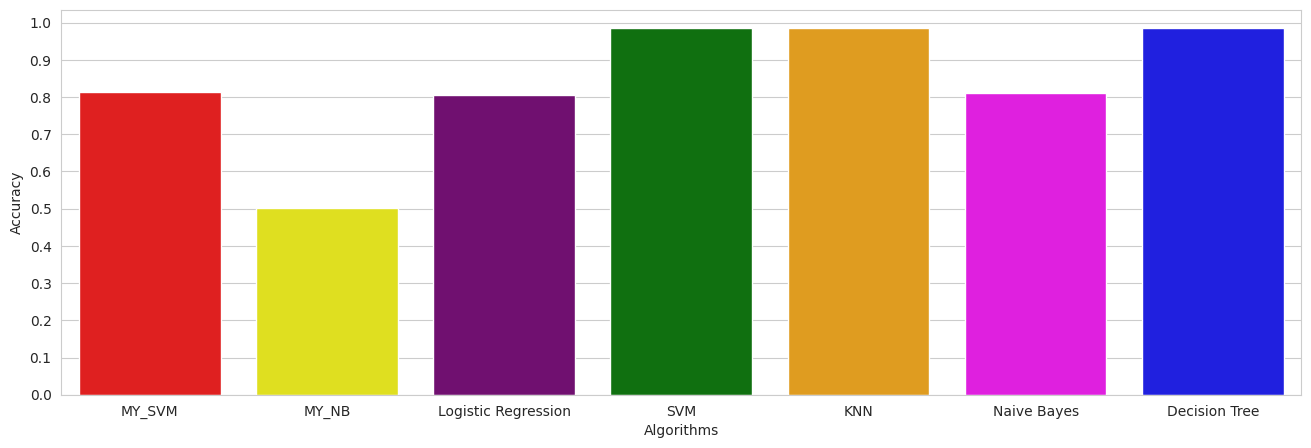

In [63]:
colors = ["red", "yellow", "purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

# Confusion Matrix

In [64]:
y_pred_my_svm = classifier.predict(x_test_scaled)
y_pred_my_nb = my_nb.predict(x_test_scaled.to_numpy())
y_pred_lr = lr.predict(x_test_scaled)
y_pred_knn = knn.predict(x_test_scaled)
y_pred_svm = svm.predict(x_test_scaled)
y_pred_nb = nb.predict(x_test_scaled)
y_pred_dtc = dtc.predict(x_test_scaled)

cm_my_svm = confusion_matrix(y_test, y_pred_my_svm)
cv_my_nb = confusion_matrix(y_test, y_pred_my_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_dt = confusion_matrix(y_test, y_pred_dtc)

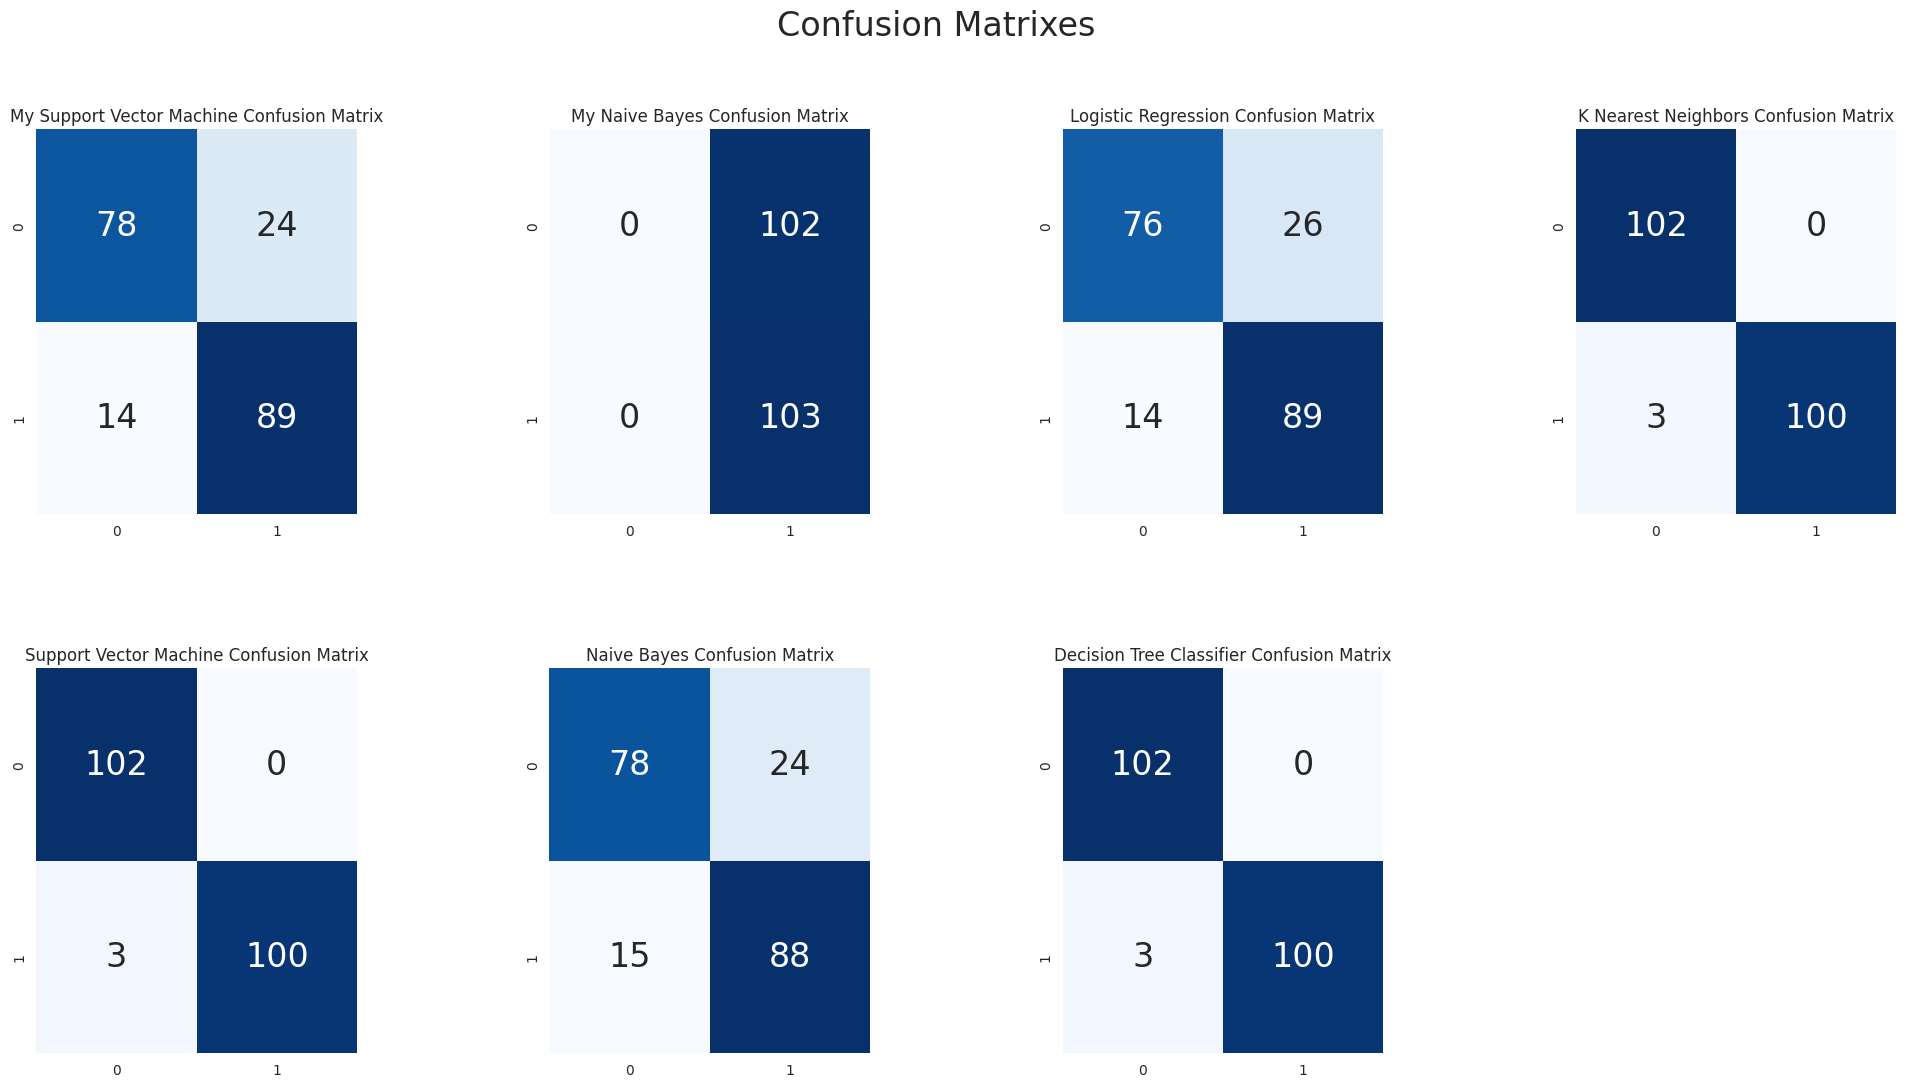

In [65]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("My Support Vector Machine Confusion Matrix")
sns.heatmap(cm_my_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("My Naive Bayes Confusion Matrix")
sns.heatmap(cv_my_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы по первому датасету

- Моя реализация SVM по качеству почти не отличается от библиотечной SVM и не хуже других методов
- Моя реализация Naive Bayes показывает результаты лучше среднего, но хуже остальных решений, хоть и с подбором параметров и кросс-валидацией
- Лучше всего себя показала Decision Tree
- Хуже всего себя показала Логистическая регрессия, но она не сильно отстает от библиотечной Naive Bayes

# Второй датасет

In [68]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## Описание датасета

- Id
- SepalLengthCm - длина чашелистика
- SepalWidthCm - ширина чашелистика
- PetalLengthCm - длина лепестка
- PetalWidthCm - ширина лепестка
- Species - тип Ириса

Необходимо при помощи моделей классификации определить тип цветка.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


У нас разнообразные типы данных, 1 целочисленный, 4 с плавающей точкой, и один имеет тип объекта. Также у нас нет никаких non-null значений.

Можем заметить, что признак Id не имеет особого для нас смысла, а потому сразу можем от него избавиться.

In [70]:
df = df.drop('Id', axis=1)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Предварительный анализ

Посмотрим на количество цветков каждого вида

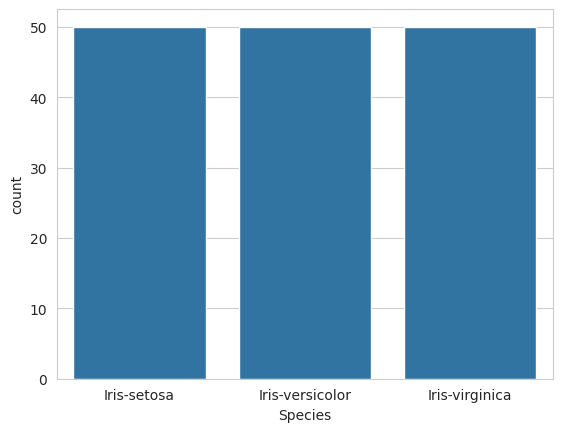

In [71]:
sns.countplot(x="Species", data=df)
plt.show()

Имеем по 50 цветков каждого типа.

Посмотрим на распределение признаков

<Axes: xlabel='PetalWidthCm', ylabel='Count'>

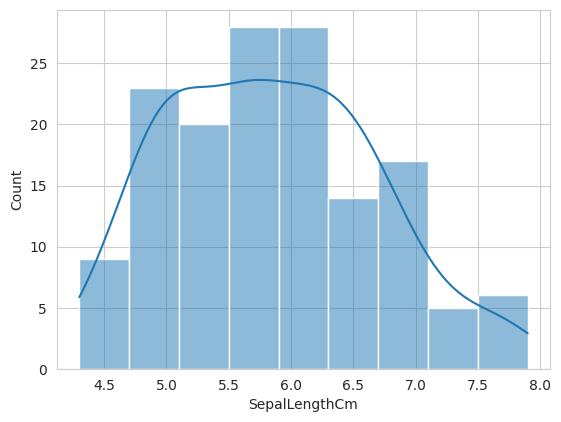

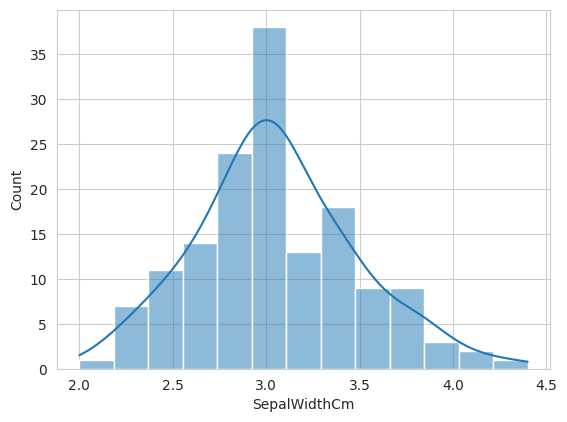

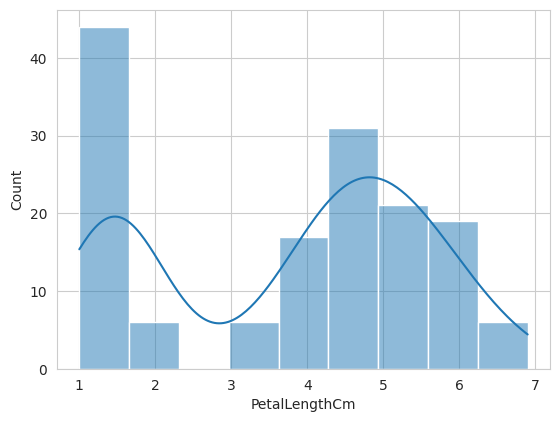

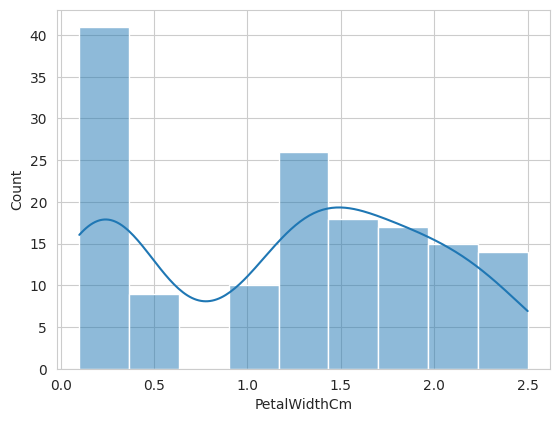

In [72]:
fig = plt.figure(figsize = (14, 10))
fig.subplots_adjust(top = 0.9)
ax_1=fig.add_subplot(2, 2, 1)
sns.histplot(data = df, x = df['SepalLengthCm'], kde = True)

fig = plt.figure(figsize = (14, 10))
fig.subplots_adjust(top = 0.9)
ax_1=fig.add_subplot(2, 2, 2)
sns.histplot(data = df, x = df['SepalWidthCm'], kde = True)

fig = plt.figure(figsize = (14, 10))
fig.subplots_adjust(top = 0.9)
ax_1=fig.add_subplot(2, 2, 3)
sns.histplot(data = df, x = df['PetalLengthCm'], kde = True)

fig = plt.figure(figsize = (14, 10))
fig.subplots_adjust(top = 0.9)
ax_1=fig.add_subplot(2, 2, 3)
sns.histplot(data = df, x = df['PetalWidthCm'], kde=True)


Имеем, что данные имеют нормальное распределение с небольшими отклонениями у параметров лепестка.

# EDA

Посмотрим на зависимость признаков друг от друга, разделенные по типам цветков

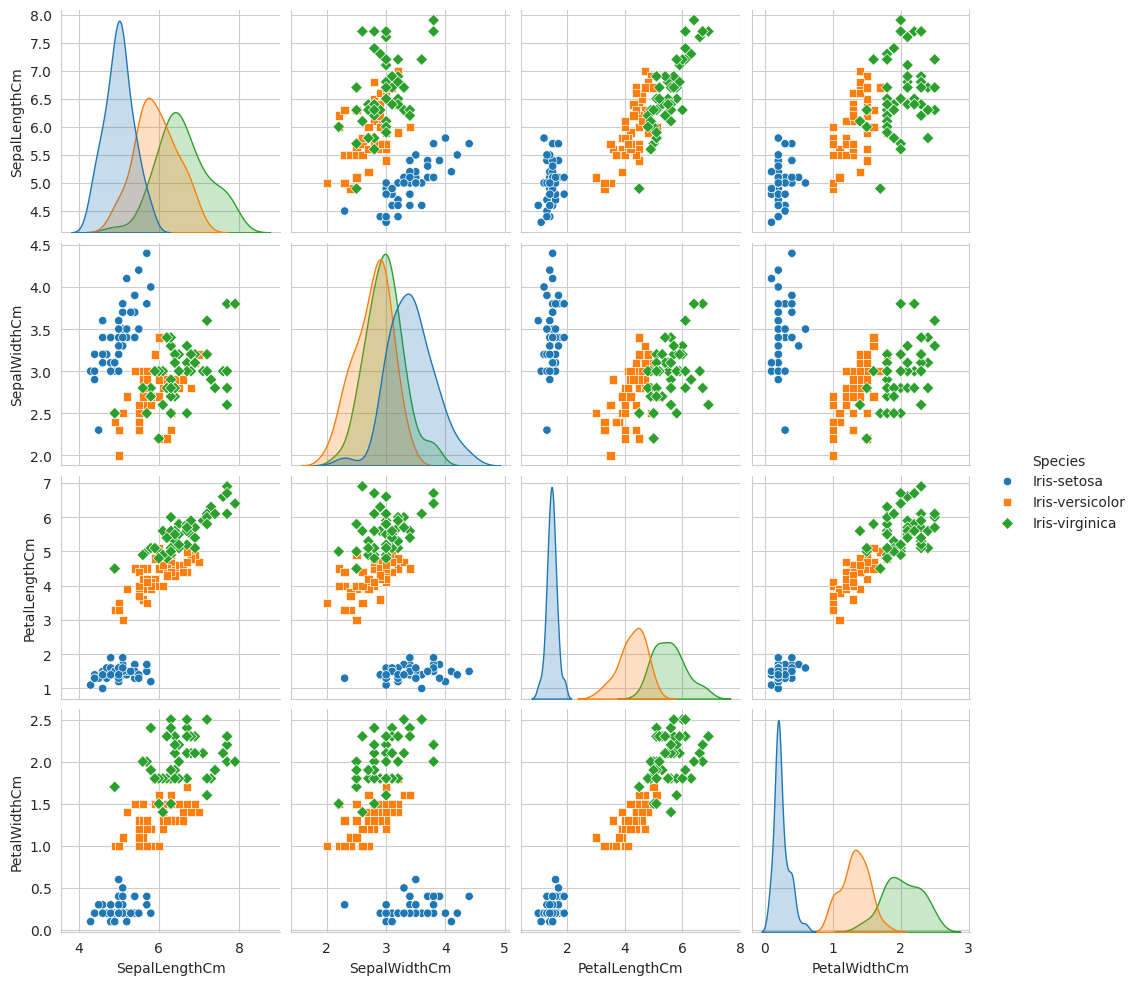

In [73]:
sns.pairplot(df, hue='Species', markers=['o', 's', 'D'], vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])

- Типы цветков заметно отделены друг от друга в плане распределений, особенно хорошо это проявляется на параметрах лепестка у цветка
- Iris-setosa довольно сильно отличается в плане признаков от других типов

Мы поняли, что параметры лепестка хорошо позволяют определить тип цветка, что нельзя сказать про чашелистик.
Посмотрим на это через распределения данных для чашелистика в зависимости от типа цветка при помощи jointplot

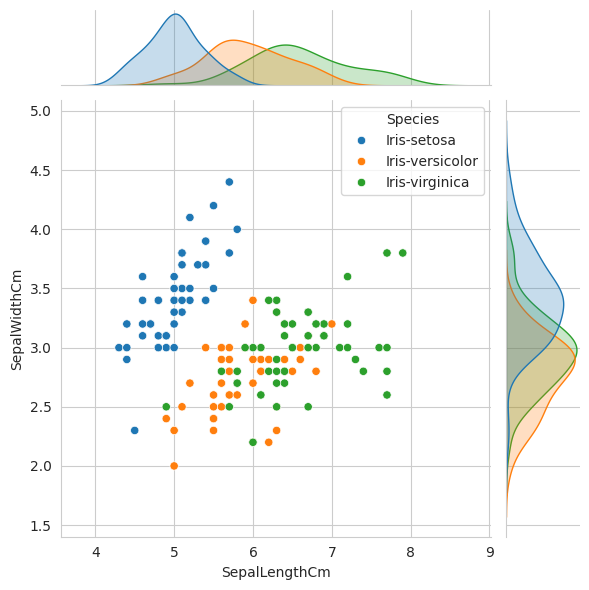

In [74]:
sns.jointplot(x='SepalLengthCm', y='SepalWidthCm', data=df, hue='Species')

- Опять же, Iris-setosa очень сильно отличается от распределений других типов, его довольно просто классифицировать
- Распределения Iris-versicolor от Iris-virginica перекрываются.
- Iris-setosa, чаще имеет короткую длину чашелистика, но более широкую ширину чашелистика

Посмотрим на корреляцию признаков, и перед этим закодируем признак типа цветка

In [75]:
le = LabelEncoder()
df['Species'] = le.fit_transform(df['Species'])
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


<Axes: >

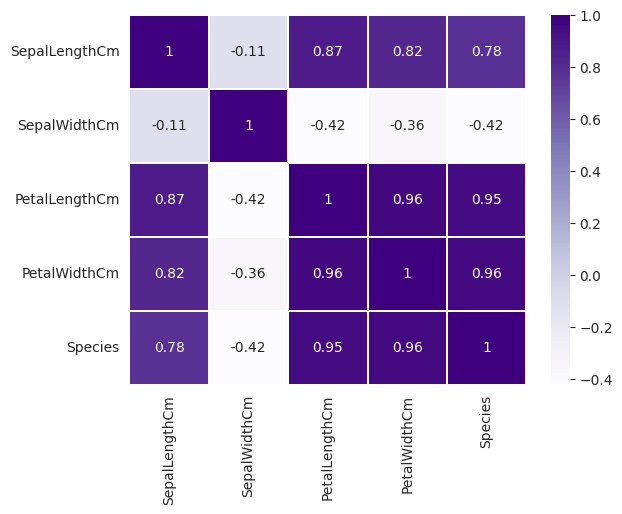

In [76]:
sns.heatmap(df.corr(), annot=True, cmap='Purples', linewidths=0.1)

Видим достаточно большую корреляцию у всех признаков, кроме SepalWidthCm, здесь она отрицательная.

# Feature Engineering

## Преобразование категориальных данных

Мы уже закодировали категориальные данные выше.

## Разделение выборки

In [77]:
x = df.drop(['Species'], axis=1)
y = df['Species']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Масштабирование

In [78]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-1.473937,1.220379,-1.563987,-1.309484
1,-0.133071,3.020017,-1.277280,-1.042922
2,1.085898,0.095606,0.385621,0.289886
3,-1.230143,0.770470,-1.219939,-1.309484
4,-1.717731,0.320560,-1.391963,-1.309484


## Подбор наилучших признаков

In [79]:
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  3
Выбранные признаки:  ['SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']


Избавимся от ненужных признаков

In [80]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1.220379,-1.563987,-1.309484
1,3.020017,-1.277280,-1.042922
2,0.095606,0.385621,0.289886
3,0.770470,-1.219939,-1.309484
4,0.320560,-1.391963,-1.309484


# Подбор гиперпараметров

## SVMClassifier - моя реализация

In [81]:
learning_rate_grid = [0.1, 0.001, 0.0001]
iter_num_grid = [100, 1000, 5000, 10000]
lmda_grid = [0.1, 0.001, 0.0001]

cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMClassifier(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lmda": lmda_grid}],
                        cv=cv, verbose=5)
_ = searcher.fit(x_train_scaled, y_train)

optimal_learning_rate = searcher.best_params_["learning_rate"]
print("Best learning_rate = %.4f:", optimal_learning_rate)

optimal_iter_num = searcher.best_params_["iter_num"]
print("Best iter_num = %.4f", optimal_iter_num)

optimal_lmda = searcher.best_params_["lmda"]
print("Best lmda = %.4f", optimal_lmda)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.708 total time=   0.1s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.667 total time=   0.1s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.667 total time=   0.1s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.667 total time=   0.1s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.1;, score=0.625 total time=   0.1s
[CV 1/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.708 total time=   0.1s
[CV 2/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.667 total time=   0.1s
[CV 3/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.667 total time=   0.1s
[CV 4/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.667 total time=   0.1s
[CV 5/5] END iter_num=100, learning_rate=0.1, lmda=0.001;, score=0.667 total time=   0.1s
[CV 1/5] END iter_num=100, learning_rate=0.1, lm

## NBClassifier - моя реализация

In [82]:
priors_grid = [None, [0.62, 0.19, 0.19], [0.3, 0.3, 0.4]]
alpha_grid = np.linspace(1, 150, num=100)

nb = NBClassifier()
cv = StratifiedKFold(5)

searcher = GridSearchCV(nb,
                        [{"priors": priors_grid, "alpha": alpha_grid}],
                        cv=cv)
searcher.fit(x_train_scaled.to_numpy(), y_train.to_numpy())

print("best estimator: " + str(searcher.best_estimator_))
print("best params: " + str(searcher.best_params_))
print('best score:', searcher.best_score_)

Выходные данные были обрезаны до нескольких последних строк (5000).
       [ 0.99542457, -1.33462153, -1.30948358],
       [ 0.77046987, -1.33462153, -1.30948358],
       [ 0.99542457, -1.39196294, -1.17620281],
       [ 1.67028869, -1.04791443, -1.04292204],
       [ 0.77046987, -1.04791443, -1.30948358],
       [-0.12934896, -1.21993869, -1.30948358],
       [ 0.54551516, -1.16259727, -0.90964127],
       [ 0.77046987, -1.27728011, -1.30948358],
       [ 0.32056046, -1.33462153, -1.30948358],
       [ 2.57010752, -1.33462153, -1.30948358],
       [ 1.8952434 , -1.16259727, -1.04292204],
       [ 0.54551516, -1.33462153, -1.30948358],
       [ 0.32056046, -1.44930436, -1.30948358],
       [ 0.09560575, -1.27728011, -1.44276436],
       [ 0.77046987, -1.27728011, -1.30948358],
       [ 1.67028869, -1.21993869, -1.30948358],
       [-1.7040319 , -1.39196294, -1.17620281],
       [ 1.44533399, -1.27728011, -1.30948358],
       [ 1.44533399, -1.27728011, -1.04292204],
       [ 0.09560575,

## LogisticRegression библиотечный

In [83]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(x_train_scaled, y_train)

print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

best estimator: LogisticRegression(C=1.1000100000000002)
best params: {'C': 1.1000100000000002}
best score: 0.9666666666666668


## SVM библиотечный

In [84]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv,
                        param_grid=dict(kernel=kernel, C=C, gamma=gamma))
grid_svm.fit(x_train_scaled, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)
print("test score:", grid_svm.score(x_test_scaled, y_test))

best score:  0.9666666666666668
best param:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
test score: 0.9666666666666667


## KNN библиотечный

In [85]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
scoring = {'Accuracy': 'accuracy', 'Log_loss': 'neg_log_loss'}

knn = KNeighborsClassifier()
std_scale = StandardScaler()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12)

knn_clf = GridSearchCV(estimator=knn, cv=rskfold,
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy')

knn_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(knn_clf.best_estimator_))
print("best params: " + str(knn_clf.best_params_))
print('best score:', knn_clf.best_score_)

best estimator: KNeighborsClassifier(n_neighbors=7)
best params: {'n_neighbors': 7, 'weights': 'uniform'}
best score: 0.9566666666666667


## Naive Bayes библиотечный

In [86]:
priors = [None, [0.62, 0.19, 0.19], [0.3, 0.3, 0.4]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'Log_loss': 'neg_log_loss'}

nb = GaussianNB()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=23)

nb_clf = GridSearchCV(estimator=nb, cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')

nb_clf.fit(x_train_scaled, y_train)

print("best estimator: " + str(nb_clf.best_estimator_))
print("best params: " + str(nb_clf.best_params_))
print('best score:', nb_clf.best_score_)

best estimator: GaussianNB(priors=[0.3, 0.3, 0.4], var_smoothing=0.012328467394420659)
best params: {'priors': [0.3, 0.3, 0.4], 'var_smoothing': 0.012328467394420659}
best score: 0.9516666666666667


## Decision Tree библиотечный

In [87]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv,
                       param_grid=dict(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features=max_features))
grid_dt.fit(x_train_scaled, y_train)
print("best score: ", grid_dt.best_score_)
print("best param: ", grid_dt.best_params_)
print("test score:", grid_dt.score(x_test_scaled, y_test))

best score:  0.9666666666666666
best param:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
test score: 1.0


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Тестирование моделей

Запустим необходимые модели с подстановкой подобранных гиперпараметров

In [88]:
accuracies = {}

## SVMClassifier - моя реализация

In [89]:
classifier = SVMClassifier(learning_rate=0.1, iter_num=100, lmda=0.01)
classifier.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = classifier.predict(x_test_scaled)
acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.6333


## NBClassifier - моя реализация

In [90]:
my_nb = NBClassifier(priors=[0.3, 0.3, 0.4])
my_nb.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
y_test_prediction = my_nb.predict(x_test_scaled.to_numpy())

acc = accuracy_score(y_test, y_test_prediction)

accuracies['MY_NB'] = acc
print("Test Accuracy of My Naive Bayes Algorithm: {:.4f}".format(acc))

{0: array([[ 1.22037928, -1.5639872 , -1.30948358],
       [ 3.02001693, -1.27728011, -1.04292204],
       [ 0.77046987, -1.21993869, -1.30948358],
       [ 0.32056046, -1.39196294, -1.30948358],
       [ 0.99542457, -1.27728011, -1.30948358],
       [ 1.22037928, -1.33462153, -1.30948358],
       [ 2.34515281, -1.27728011, -1.44276436],
       [ 1.8952434 , -1.39196294, -1.04292204],
       [ 1.44533399, -1.27728011, -1.30948358],
       [ 0.99542457, -1.33462153, -1.30948358],
       [ 0.77046987, -1.33462153, -1.30948358],
       [ 0.99542457, -1.39196294, -1.17620281],
       [ 1.67028869, -1.04791443, -1.04292204],
       [ 0.77046987, -1.04791443, -1.30948358],
       [-0.12934896, -1.21993869, -1.30948358],
       [ 0.54551516, -1.16259727, -0.90964127],
       [ 0.77046987, -1.27728011, -1.30948358],
       [ 0.32056046, -1.33462153, -1.30948358],
       [ 2.57010752, -1.33462153, -1.30948358],
       [ 1.8952434 , -1.16259727, -1.04292204],
       [ 0.54551516, -1.33462153, -1

## LogisticRegression библиотечный

In [91]:
lr = LogisticRegression(C=1.1000100000000002)
lr.fit(x_train_scaled, y_train)
acc = lr.score(x_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 1.0000


## SVM библиотечный

In [92]:
svm = SVC(C=1, gamma='scale', kernel='linear', random_state=11)
svm.fit(x_train_scaled, y_train)

acc = svm.score(x_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9667


## KNN библиотечный

In [93]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train_scaled, y_train)

acc = knn.score(x_test_scaled, y_test)
accuracies['KNN'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 1.0000


## Naive Bayes библиотечный

In [94]:
nb = GaussianNB(priors=[0.3, 0.3, 0.4], var_smoothing=0.012328467394420659)
nb.fit(x_train_scaled, y_train)

acc = nb.score(x_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 1.0000


## Decision Tree библиотечный

In [95]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=5,
                             splitter='random')
dtc.fit(x_train, y_train)

acc = dtc.score(x_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9333


## Сравнение моделей

<ipython-input-96-b71afc86a232>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)


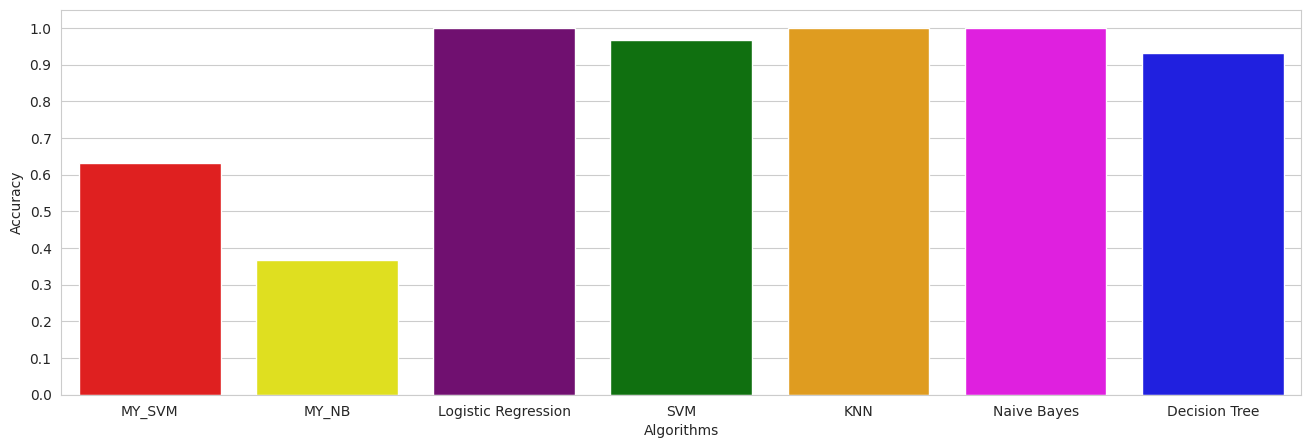

In [96]:
colors = ["red", "yellow", "purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

# Confusion Matrix

In [97]:
y_pred_my_svm = classifier.predict(x_test_scaled)
y_pred_my_nb = my_nb.predict(x_test_scaled.to_numpy())
y_pred_lr = lr.predict(x_test_scaled)
y_pred_knn = knn.predict(x_test_scaled)
y_pred_svm = svm.predict(x_test_scaled)
y_pred_nb = nb.predict(x_test_scaled)
y_pred_dtc = dtc.predict(x_test)

cm_my_svm = confusion_matrix(y_test, y_pred_my_svm)
cv_my_nb = confusion_matrix(y_test, y_pred_my_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_dt = confusion_matrix(y_test, y_pred_dtc)

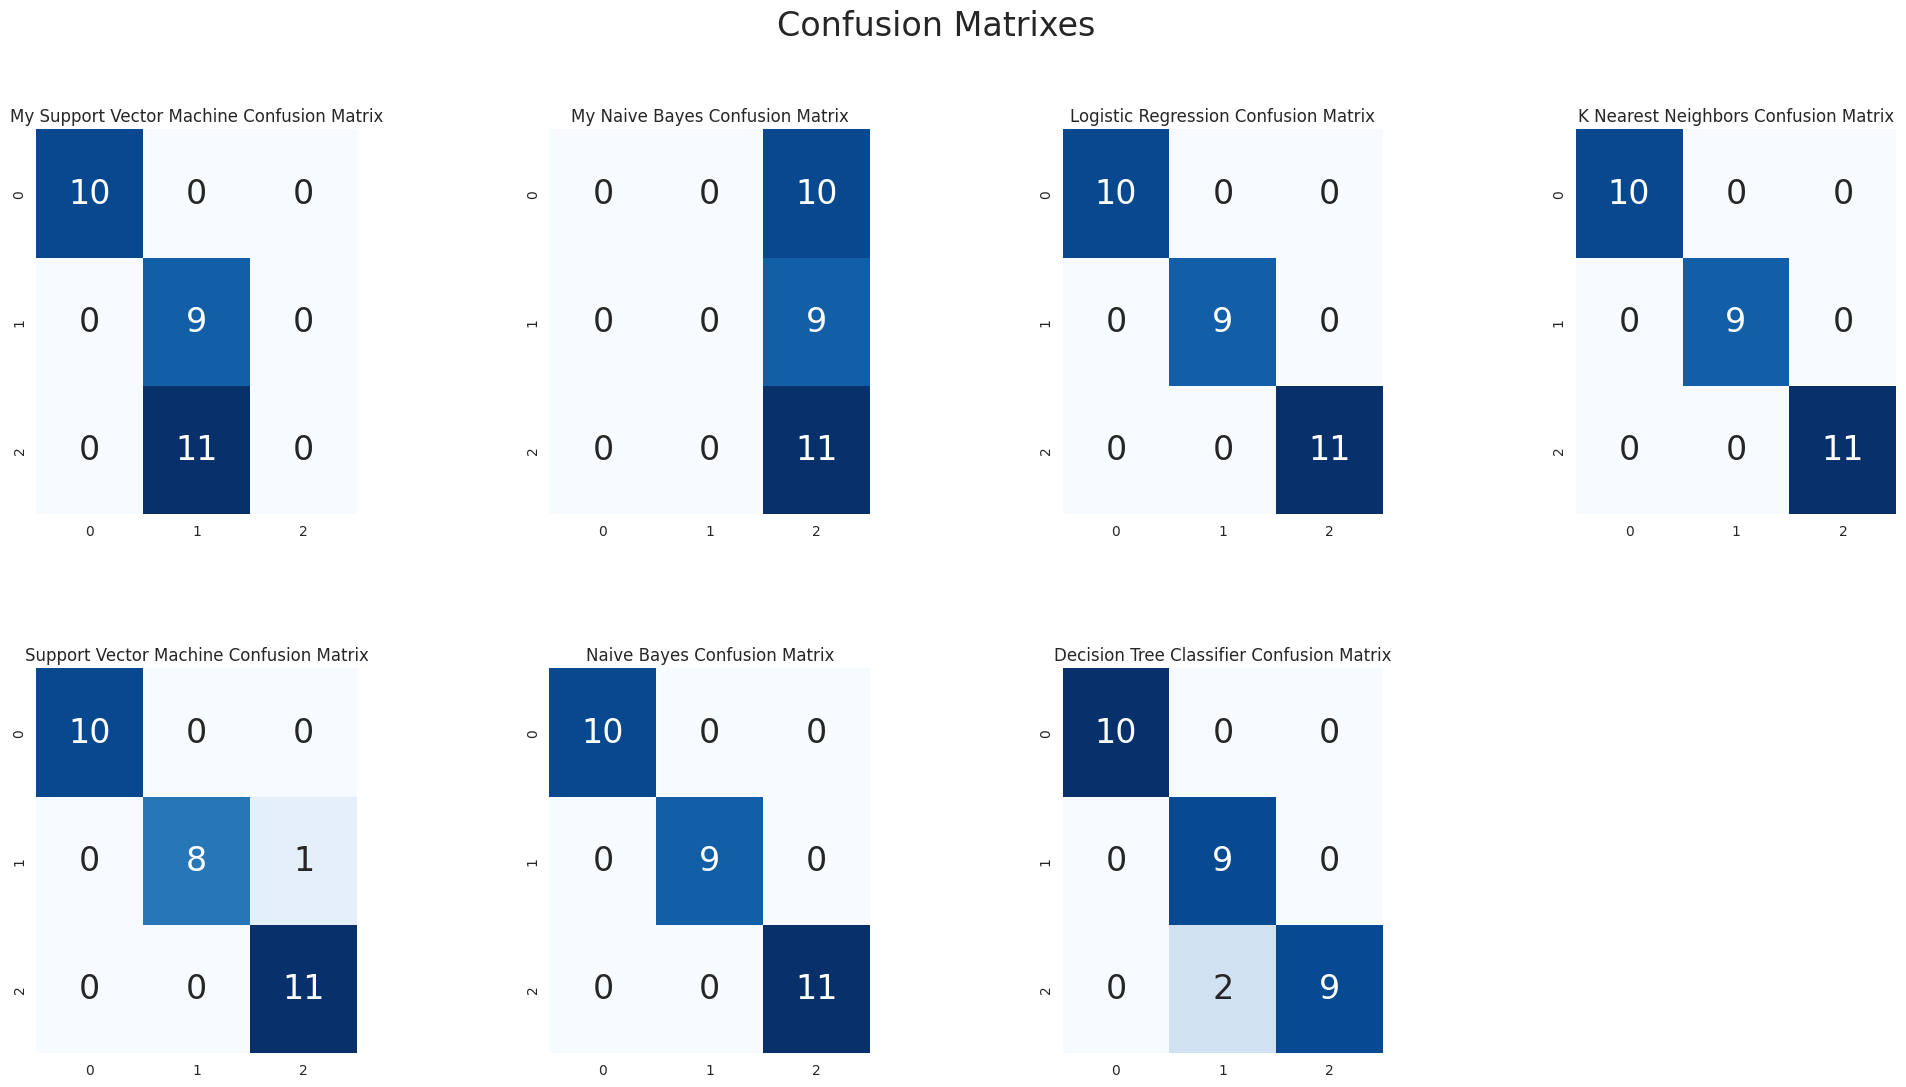

In [98]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace=0.6, hspace=0.4)

plt.subplot(2, 4, 1)
plt.title("My Support Vector Machine Confusion Matrix")
sns.heatmap(cm_my_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 2)
plt.title("My Naive Bayes Confusion Matrix")
sns.heatmap(cv_my_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 3)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 4)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dt, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы
- Реализованные алгоритмы показывают себя хуже, чем библиотечные варианты, особенно Naive Bayes. Вероятно, дело в сильной корреляции признаков, а первичная реализация опирается на предположение о независимости признаков.
- Библиотечные реализации почти все показывают отличные результаты, немного хуже себя показывают разве что SVM и Decision Tree.